In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from module import FlowMatchingModel 

In [2]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG/checkpoints/best-model-epoch=76-val_loss=0.002039.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG/checkpoints/best-model-epoch=76-val_loss=0.002039.ckpt


In [3]:
def predict_star_map(total_mass_map,condition=None,num_steps=100):

    # Convert to tensor: (1, 1, H, W)
    input_tensor = torch.FloatTensor(total_mass_map).unsqueeze(0).unsqueeze(0).to(device)

    if condition is None:
        condition_tensor = input_tensor
    else:
        condition_tensor = torch.FloatTensor(condition).unsqueeze(0).unsqueeze(0).to(device)
    
    # Generate star map
    with torch.no_grad():
        output = model.sample(input_tensor, condition_tensor, num_steps=num_steps)
    
    # Convert back to numpy and denormalize
    star_map = output[0, 0].cpu().numpy()  # Shape: (H, W)
    gas_map = output[0, 1].cpu().numpy()   # Shape: (H, W)
    
    return star_map, gas_map

In [4]:
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')
star_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy')
gas_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy')

tot = np.log1p(total_mass_maps)
star = np.log1p(star_maps)
gas = np.log1p(gas_maps)
tot_mean,tot_std = tot.mean(), tot.std()
star_mean,star_std = star.mean(), star.std()
gas_mean,gas_std = gas.mean(), gas.std()

data_stats = {
    'tot_mean': tot_mean,
    'tot_std': tot_std,
    'star_mean': star_mean,
    'star_std': star_std,
    'gas_mean': gas_mean,
    'gas_std': gas_std
}

sample_tot = np.log1p(total_mass_maps[0])

sample_tot = (sample_tot - data_stats['tot_mean'])/data_stats['tot_std']

pred_star, pred_gas = predict_star_map(sample_tot, num_steps=300)
true_star = (np.log1p(star_maps[0]) - data_stats['star_mean'])/data_stats['star_std']
true_gas = (np.log1p(gas_maps[0]) - data_stats['gas_mean'])/data_stats['gas_std']

Final x shape: torch.Size([1, 2, 256, 256])


In [5]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG02/checkpoints/best-model-epoch=107-val_loss=0.020540.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG02/checkpoints/best-model-epoch=107-val_loss=0.020540.ckpt


In [15]:
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')

tot = np.log1p(total_mass_maps)
tot_mean,tot_std = tot.mean(), tot.std()

data_stats = {
    'tot_mean': tot_mean,
    'tot_std': tot_std
}

sample_tot = np.log1p(total_mass_maps[0])
sample_tot = (sample_tot - data_stats['tot_mean'])/data_stats['tot_std']

noisy_tot = [sample_tot + np.random.normal(loc=0,scale=0.2,size=(256,256)) for i in range(3)]
sample_tot = [sample_tot for i in range(5)]

noisy_pred = [predict_star_map(noisy, cond, num_steps=300) for noisy, cond in zip(noisy_tot,sample_tot)]

Final x shape: torch.Size([1, 2, 256, 256])
Final x shape: torch.Size([1, 2, 256, 256])
Final x shape: torch.Size([1, 2, 256, 256])


In [16]:
import Pk_library as PKL

noisy_pred = np.asarray(noisy_pred)
noisy_star = noisy_pred[:,0]
noisy_gas = noisy_pred[:,1]

def get_pk(mat):
    BoxSize = 25.0    
    MAS     = 'None'  
    threads = 1       
    pk = PKL.Pk_plane(mat,BoxSize,MAS,threads,verbose=False)
    return pk.k, pk.Pk

In [17]:
k_pred_star, Pk_pred_star = get_pk(pred_star)
k_true_star, Pk_true_star = get_pk(true_star)

k_pred_gas, Pk_pred_gas = get_pk(pred_gas)
k_true_gas, Pk_true_gas = get_pk(true_gas)

noisy_star_pk = [get_pk(mat) for mat in noisy_star]
noisy_gas_pk = [get_pk(mat) for mat in noisy_gas]

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_578514/2333442081.py:37: SyntaxWarning: invalid escape sequence '\s'
  ax_star.loglog(k, pk, linewidth=2, alpha=0.5, ls='--',color='gray',label='$\sigma=0.2$')
/tmp/ipykernel_578514/2333442081.py:53: SyntaxWarning: invalid escape sequence '\s'
  ax_gas.loglog(k, pk, linewidth=2, alpha=0.5, ls='--',color='gray',label='$\sigma=0.2$')


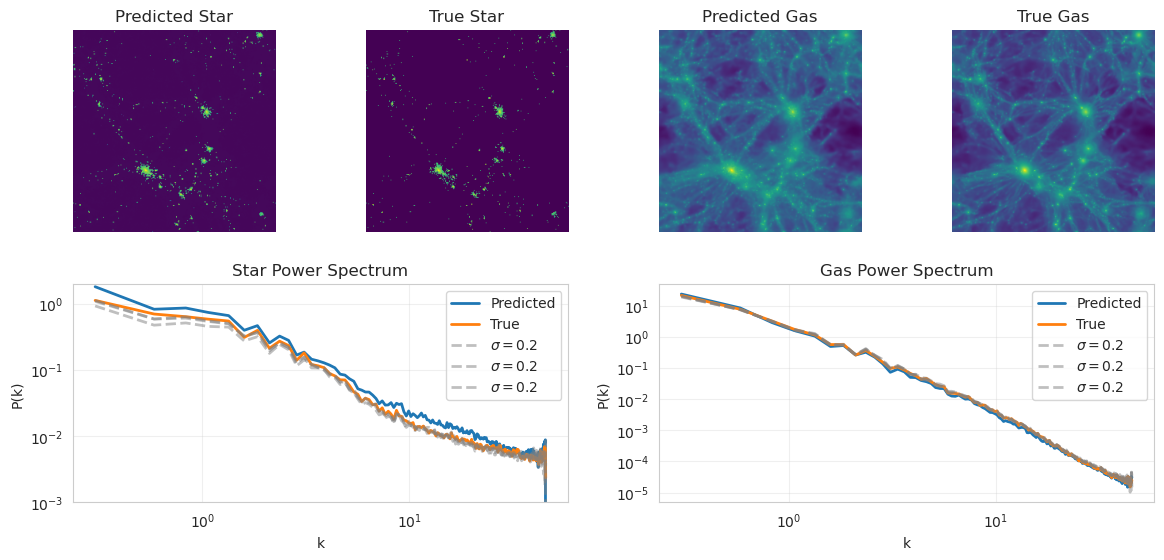

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Create figure with tighter layout
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Top row: Images
axes[0,0].imshow(pred_star, cmap='viridis')
axes[0,0].set_title("Predicted Star")
axes[0,0].axis('off')

axes[0,1].imshow(true_star, cmap='viridis')
axes[0,1].set_title("True Star")
axes[0,1].axis('off')

axes[0,2].imshow(pred_gas, cmap='viridis')
axes[0,2].set_title("Predicted Gas")
axes[0,2].axis('off')

axes[0,3].imshow(true_gas, cmap='viridis')
axes[0,3].set_title("True Gas")
axes[0,3].axis('off')

# Bottom row: Power spectra (merge pairs)
axes[1,0].remove()
axes[1,1].remove()
ax_star = plt.subplot2grid((2, 4), (1, 0), colspan=2)

ax_star.loglog(k_pred_star, Pk_pred_star, label="Predicted", linewidth=2)
ax_star.loglog(k_true_star, Pk_true_star, label="True", linewidth=2)
for pks in noisy_star_pk:
    k,pk = pks
    ax_star.loglog(k, pk, linewidth=2, alpha=0.5, ls='--',color='gray',label='$\sigma=0.2$')
ax_star.set_title("Star Power Spectrum")
ax_star.set_xlabel("k")
ax_star.set_ylabel("P(k)")
ax_star.set_ylim(1e-3, 2)
ax_star.legend()
ax_star.grid(True, alpha=0.3)

axes[1,2].remove()
axes[1,3].remove()
ax_gas = plt.subplot2grid((2, 4), (1, 2), colspan=2)

ax_gas.loglog(k_pred_gas, Pk_pred_gas, label="Predicted", linewidth=2)
ax_gas.loglog(k_true_gas, Pk_true_gas, label="True", linewidth=2)
for pks in noisy_gas_pk:
    k,pk = pks
    ax_gas.loglog(k, pk, linewidth=2, alpha=0.5, ls='--',color='gray',label='$\sigma=0.2$')
ax_gas.set_title("Gas Power Spectrum")
ax_gas.set_xlabel("k")
ax_gas.set_ylabel("P(k)")
ax_gas.legend()
ax_gas.grid(True, alpha=0.3)

plt.tight_layout(pad=2.0)
plt.savefig("sample_noise.png", dpi=300, bbox_inches='tight')
plt.show()